In [1]:
import anndata as ad
import scanpy as sc
import squidpy as sq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from scipy.stats import stats
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list, fcluster

from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV

from scipy.stats import spearmanr
from scipy.stats import pearsonr

import seaborn as sns
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap

In [165]:
fdata.var_names[fdata.var_names.str.startswith("H2")]

Index(['H2-Aa', 'H2-Ab1', 'H2-D1', 'H2-DMa', 'H2-DMb1', 'H2-DMb2', 'H2-Eb1',
       'H2-Eb2', 'H2-K1', 'H2-M2', 'H2-M3', 'H2-M5', 'H2-M9', 'H2-Oa', 'H2-Ob',
       'H2-Q1', 'H2-Q10', 'H2-Q2', 'H2-Q4', 'H2-Q6', 'H2-Q7', 'H2-T22',
       'H2-T23', 'H2-T24', 'H2afj', 'H2afv', 'H2afx', 'H2afy', 'H2afy2',
       'H2afz'],
      dtype='object')

In [2]:
markers = {
    "Neutrophils": ["PTPRC", "S100A9", "MPO", "CXCR2", "CSF3R", "AQP9"],
    "Macrophages": ["PTPRC", "CD14", "ITGAM", "ITGAX", "TREM2", "FCGR3A", "FCGR3B", "CCR2", "CD163", "CD68", "ARG1", "ADGRE1", "CD33", "CD68", "C1QA", "CD163",  "C1QB", "C1QC",  "MARCO", "CD81"],
    # "cDC1": ["CLEC9A", "FLT3", "IDO1"],
    # "cDC2": ["CD1C", "FCER1A"],
    # "cDC3": ["LAMP3", "CCR7", "FSCN1"],
    # "pDC": ["LILRA4", "GZMB", "IL3RA"],
    # "Mono_CD14": ["FCN1", "S100A9", "S100A8"],
    # "Mono_CD16": ["FCGR3A", "LST1", "LILRB2"],
    # "Macro_INHBA": ["INHBA", "IL1RN", "CCL4"],
    # "Macro_NLRP3": ["NLRP3", "EREG", "IL1B"],
    # "Macro_LYVE1": ["LYVE1", "PLTP", "SEPP1"],
    # "Macro_C1QC": ["C1QC", "C1QA", "APOE"],
    # "Mast": ["KIT", "TPSAB1", "CPA3"],
    "DC": ["PTPRC", "ITGAM", "ITGAX", "CD14", "CD33", "CD68", "CD1C", "CD209", "CCL22", "CD86", "CLEC9A", "CLEC10A", "XCR1", "LAMP3"],
    "Endothelial": ["VWF", "PECAM1", "CLDN5","CDH5","MGP"],
    "Epithelial": ["CDH1", "EPCAM", "CDKN2A", "KRT5", "KRT17", "MUC5B"],
    "Neutrophils": ["PTPRC", "S100A9", "MPO", "CXCR2", "CSF3R", "AQP9"],
    "Malignant": ["MUC1", "FXYD3", "MKI67", "MDK", "SOX4", "S100P",  "EPCAM", "ATP1B1"],
    "Monocyte": ["FCN1", "LYZ", "CD14", "S100A8", "CFP"],
    "Fibroblasts": ["COL1A1", "COL1A2", "COL3A1","MMP2", "MYL9", "DCN","FAP"],
}

In [3]:
T_markers = {
    "memory T": ["Il7r", "Cd27", "Timp1"],
    "effector T": ["Gzmk", "Gzma", "Gzmb", "Prf1", "Nkg7"],
    "exhausted T": ["Havcr2", "Lag3", "Entpd1", "Tigit", "Ctla4", "Layn"],
    "stem-like T": ["Tcf7", "Foxo1"]
}

In [4]:
fdata = ad.read_h5ad("./RNA/Multitime.clustered.h5")
cdata = ad.read_h5ad("./RNA/Multitime.guide.h5")

In [5]:
def gene_mouse(str_):
    return [t[0] + t[1:].lower() for t in str_]

In [6]:
sgs = cdata.var_names.str.split('_', n=1).str[0]
sgs_grouped = pd.DataFrame(cdata.X.toarray(), columns=cdata.var_names)
sgs_grouped = sgs_grouped.groupby(sgs, axis=1).sum()
sgdata = ad.AnnData(sgs_grouped, obs=cdata.obs, var=pd.DataFrame(index=sgs_grouped.columns))
sgdata.obsm['spatial'] = cdata.obsm['spatial']
cdata = sgdata.copy()

/tmp/ipykernel_59289/1049114494.py:3: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  sgs_grouped = sgs_grouped.groupby(sgs, axis=1).sum()


In [7]:
def align_rna_guide_data(rnadata, guidedata, marker_name="marker"):

    rnadata.obs["cov"] = [str(marker) + '_' + str(array[0]) + "-" + str(array[1]) for marker, array in zip(rnadata.obs[marker_name], rnadata.obsm["spatial"])]
    guidedata.obs["cov"] = [str(marker) + '_' + str(array[0]) + "-" + str(array[1]) for marker, array in zip(guidedata.obs[marker_name], guidedata.obsm["spatial"])]

    guidedata.obs_names = guidedata.obs['cov']
    rnadata.obs_names = rnadata.obs['cov']
    sorted_obs_names = rnadata.obs_names.sort_values()

    common_cov = np.intersect1d(rnadata.obs['cov'], guidedata.obs['cov'])
    guidedata_filtered = guidedata[common_cov].copy()
    guidedata_filtered = guidedata_filtered[sorted_obs_names].copy()
    rnadata_reordered = rnadata[sorted_obs_names].copy()

    missing_cov = rnadata.obs['cov'][~rnadata.obs['cov'].isin(common_cov)]
    if len(missing_cov) > 0:
        missing_obs = pd.DataFrame({marker_name: [cov.split('_')[0] for cov in missing_cov]}, index=missing_cov)
        missing_obsm_spatial = np.array([[float(cov.split('_')[1].split('-')[0]), float(cov.split('_')[1].split('-')[1])] for cov in missing_cov])
        missing_X = np.zeros((len(missing_cov), guidedata.shape[1]))

        missing_guidedata = ad.AnnData(X=missing_X, obs=missing_obs, obsm={'spatial': missing_obsm_spatial})
        guidedata_filtered = guidedata_filtered.concatenate(missing_guidedata)
    return rnadata_reordered, guidedata_filtered

In [8]:
fdata, cdata = align_rna_guide_data(fdata, cdata)

In [9]:
def beta_regression(rnadata, guidedata, expr_term=[], expr_layer=None, \
    alpha_list=[0.001, 0.005, 0.01, 0.05, 0.1], max_iter=10000, l1_ratio=0.5, verbose=True):
    if len(rnadata.obs_names) != len(guidedata.obs_names):
        print("Error!, data bin count doesn't match!")
        return None
    if type(guidedata.X) == "scipy.sparse._csr.csr_matrix":
        guide_matrix = guidedata.X.toarray()
    else:
        guide_matrix = guidedata.X
    
    if all([obj in rnadata.obs for obj in expr_term]):
        if verbose: print("Extracting bin metric")
        score_df = rnadata.obs[expr_term]
        try:
            score_matrix = np.array(score_df.astype(int))
        except:
            print("Error converting obs to np.float matrix!")
            return None
    elif all([obj in rnadata.var_names for obj in expr_term]):
        if verbose: print("Extracting expression metric")
        if not expr_layer:
            if type(rnadata.X) == "scipy.sparse._csr.csr_matrix":
                score_matrix = rnadata[:, expr_term].X.toarray().T
            else:
                score_matrix = rnadata[:, expr_term].X.T
        else:
            if type(rnadata.layer[expr_layer]) == "scipy.sparse._csr.csr_matrix":
                score_matrix = rnadata[:, expr_term].layer[expr_layer].toarray().T
            else:
                score_matrix = rnadata[:, expr_term].layer[expr_layer].T
    
    corr_matrix = np.zeros((guide_matrix.shape[1], score_matrix.shape[1]))
    if verbose: print("Regressing with " + str(guide_matrix.shape[0]) + " samples, " + str(guide_matrix.shape[1]) +\
        " guides, " + str(score_matrix.shape[1]) + " objectives.")
    param_grid = { 'alpha': alpha_list }
    range_ = range(guide_matrix.shape[1])
    for i in tqdm(range_):
        guide_vector = guide_matrix[:, i]
        regr=ElasticNet(max_iter=max_iter, l1_ratio=l1_ratio)
        grid_regr = GridSearchCV(regr, param_grid, scoring='neg_mean_squared_error', cv=5, n_jobs=-1, verbose=0)
        grid_regr.fit(X=score_matrix, y=guide_vector)
        regr = grid_regr.best_estimator_
        regr.fit(X=score_matrix, y=guide_vector)
        corr_matrix[i] = regr.coef_
    corr_df = pd.DataFrame(corr_matrix, index=guidedata.var_names, columns=expr_term)
    if verbose: print("Regression done!")
    return corr_df

In [77]:
(cdata.X[:, 0]).shape

(118279,)

In [94]:
cdata.X[:, np.where(cdata.var_names == "sgNTC")[0]].T.shape

(1, 118279)

In [132]:
def calculate_correlation(rnadata, guidedata, expr_term=[], expr_layer=None, \
    corr_type="spearmanr", control=False, verbose=True):
    """
    Usage:
        calculates the correlation with rndata <expr_term> and guidedata guidecount
        the <corr_type> function specifies the correlation method, can be "spearmanr" and "pearsonr"
    Return:
        the dataframe containing each rnadata <expr_term> and guide
    """
    if len(rnadata.obs_names) != len(guidedata.obs_names):
        print("Error!, data bin count doesn't match!")
        return None
    if type(guidedata.X) == "scipy.sparse._csr.csr_matrix":
        guide_matrix = guidedata.X.toarray()
    else:
        guide_matrix = guidedata.X
    if control:
        ntc_index = np.where(guidedata.var_names == "sgNTC")[0][0]
        ntc_vector = guide_matrix[:, ntc_index].reshape(-1, 1)
    
    if all([obj in rnadata.obs for obj in expr_term]):
        if verbose: print("Extracting bin metric")
        score_df = rnadata.obs[expr_term]
        try:
            score_matrix = np.array(score_df.astype(int))
        except:
            print("Error converting obs to np.float matrix!")
            return None
    elif all([obj in rnadata.var_names for obj in expr_term]):
        if verbose: print("Extracting expression metric")
        if not expr_layer:
            if type(rnadata.X) == "scipy.sparse._csr.csr_matrix":
                score_matrix = rnadata[:, expr_term].X.toarray().T
            else:
                score_matrix = rnadata[:, expr_term].X.T
        else:
            if type(rnadata.layer[expr_layer]) == "scipy.sparse._csr.csr_matrix":
                score_matrix = rnadata[:, expr_term].layer[expr_layer].toarray().T
            else:
                score_matrix = rnadata[:, expr_term].layer[expr_layer].T
    
    corr_matrix = np.zeros((guide_matrix.shape[1], score_matrix.shape[1]))
    if verbose: print("Correlation with " + str(guide_matrix.shape[0]) + " samples, " + str(guide_matrix.shape[1]) +\
        " guides, " + str(score_matrix.shape[1]) + " objectives.")
    range_ = range(guide_matrix.shape[1])
    if control:
        if corr_type == "spearmanr":
            for i in tqdm(range_):
                if i == ntc_index: continue
                for j in range(score_matrix.shape[1]):
                    guide_vector = guide_matrix[:, i] - ntc_vector.T[0]
                    score_vector = score_matrix[:, j]
                    corr_matrix[i, j] = spearmanr(guide_vector, score_vector)[0]
        elif corr_type == "pearsonr":
            for i in tqdm(range_):
                if i == ntc_index: continue
                for j in range(score_matrix.shape[1]):
                    guide_vector = guide_matrix[:, i] - ntc_vector.T[0]
                    score_vector = score_matrix[:, j]
                    corr_matrix[i, j] = pearsonr(guide_vector, score_vector)[0]
        else:
            print("Error, cannot find correlation type " + corr_type)
            return None
    else:
        if corr_type == "spearmanr":
            for i in tqdm(range_):
                for j in range(score_matrix.shape[1]):
                    guide_vector = guide_matrix[:, i]
                    score_vector = score_matrix[:, j]
                    corr_matrix[i, j] = spearmanr(guide_vector, score_vector)[0]
        elif corr_type == "pearsonr":
            for i in tqdm(range_):
                for j in range(score_matrix.shape[1]):
                    guide_vector = guide_matrix[:, i]
                    score_vector = score_matrix[:, j]
                    corr_matrix[i, j] = pearsonr(guide_vector, score_vector)[0]
        else:
            print("Error, cannot find correlation type " + corr_type)
            return None
    corr_df = pd.DataFrame(corr_matrix, index=guidedata.var_names, columns=expr_term)
    if control:
        corr_df = corr_df.loc[corr_df.index != "sgNTC"]
    if verbose: print("Regression done!")
    return corr_df

In [10]:
for marker in markers:
    genes = gene_mouse(markers[marker])
    mean_expression = np.zeros(len(fdata.obs_names))
    for gene in genes:
        if gene in fdata.var_names:
            mean_expression += fdata[:, gene].X.toarray().flatten()
    fdata.obs[f"{marker}_score"] = mean_expression

In [11]:
mask = fdata.obs["cluster_cellcharter_givenk"] == 3
r_df = beta_regression(fdata[mask], cdata[mask], expr_term=[f"{marker}_score" for marker in markers])

Extracting bin metric
Regressing with 12394 samples, 34 guides, 8 objectives.


100%|██████████| 34/34 [00:27<00:00,  1.26it/s]

Regression done!


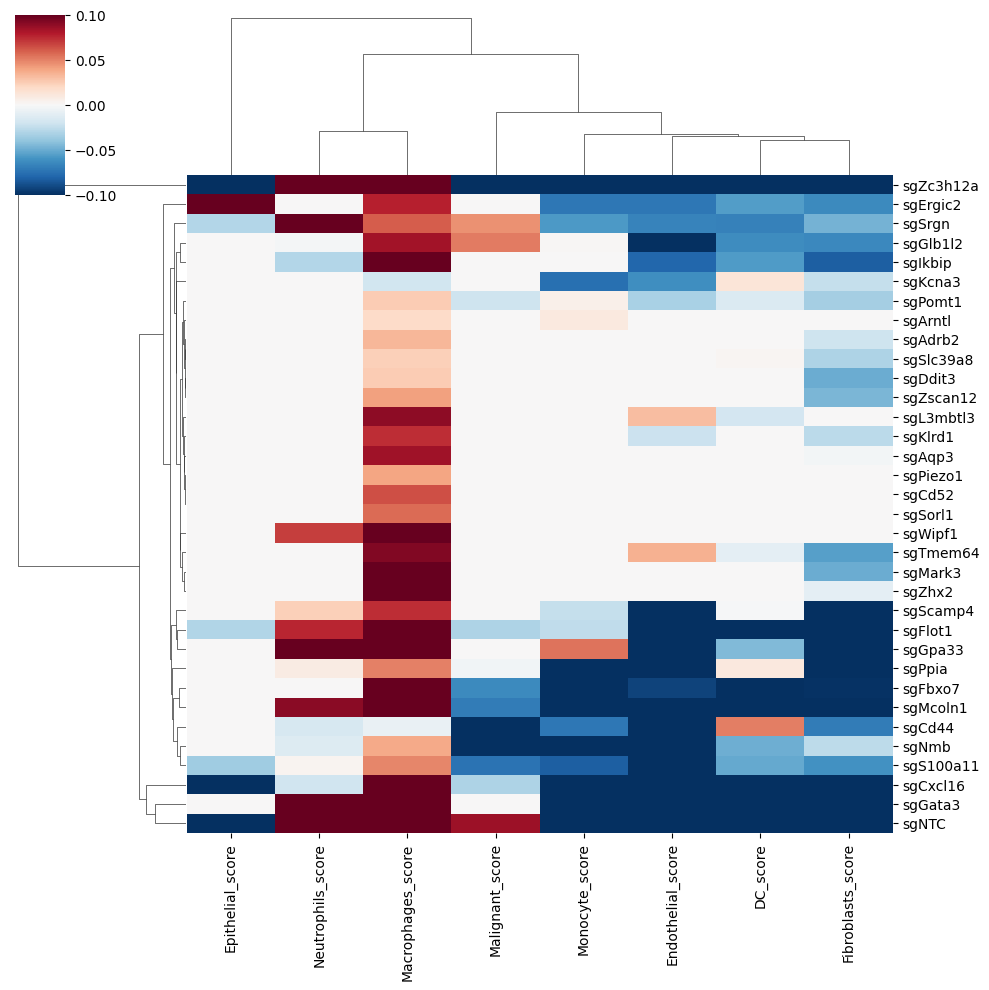

In [16]:
sns.clustermap(r_df, cmap="RdBu_r", vmin=-0.1, vmax=0.1, center=0)

In [176]:
c_df = calculate_correlation(fdata, cdata, expr_term=[f"{marker}_score" for marker in markers], control=False)

Extracting bin metric
Correlation with 118279 samples, 34 guides, 16 objectives.


100%|██████████| 34/34 [00:06<00:00,  4.93it/s]

Regression done!


Text(0.5, 1.0, 'Spearman R')

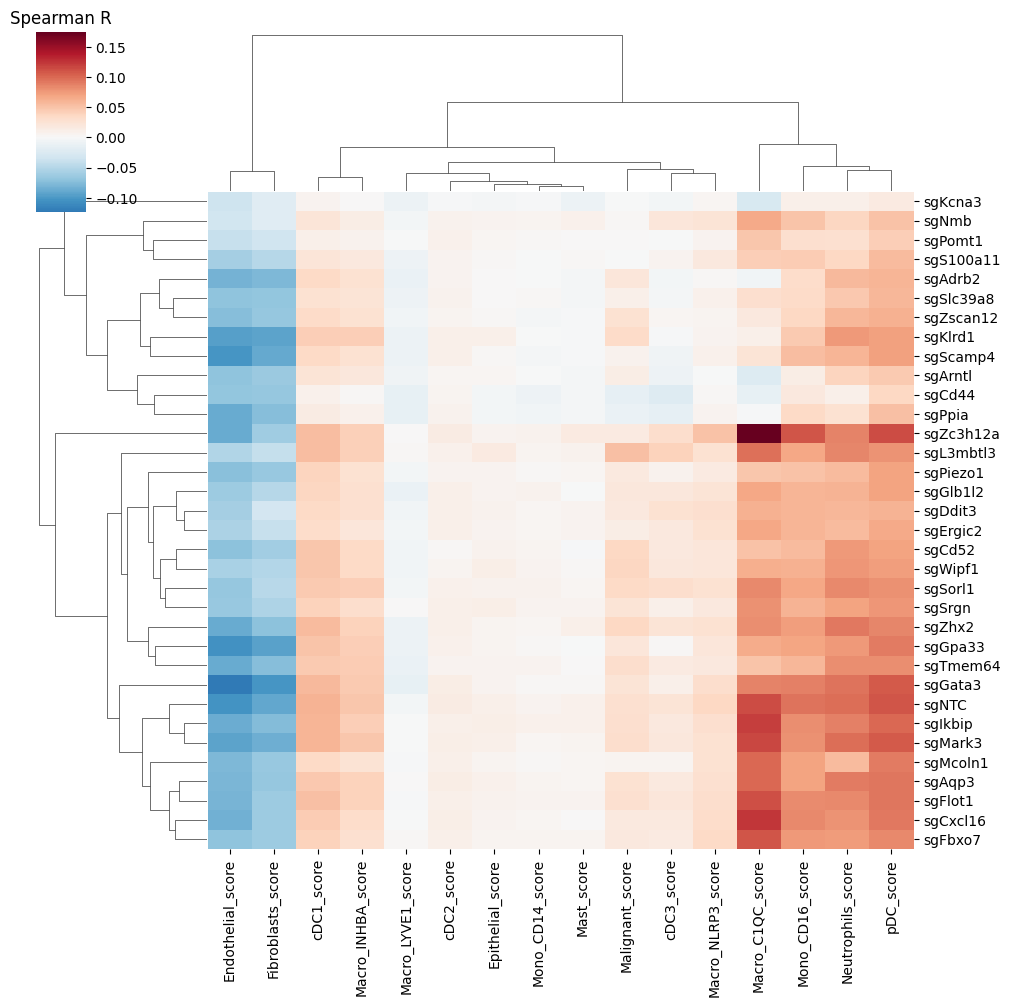

In [178]:
sns.clustermap(c_df, cmap="RdBu_r", center=0)
plt.title("Spearman R")

In [96]:
c_df = calculate_correlation(fdata, cdata, expr_term=[f"{marker}_score" for marker in markers], corr_type="pearsonr", control=True)

Extracting bin metric
Correlation with 118279 samples, 34 guides, 10 objectives.


 18%|█▊        | 6/34 [00:00<00:01, 15.97it/s]

100%|██████████| 34/34 [00:01<00:00, 18.22it/s]

Regression done!


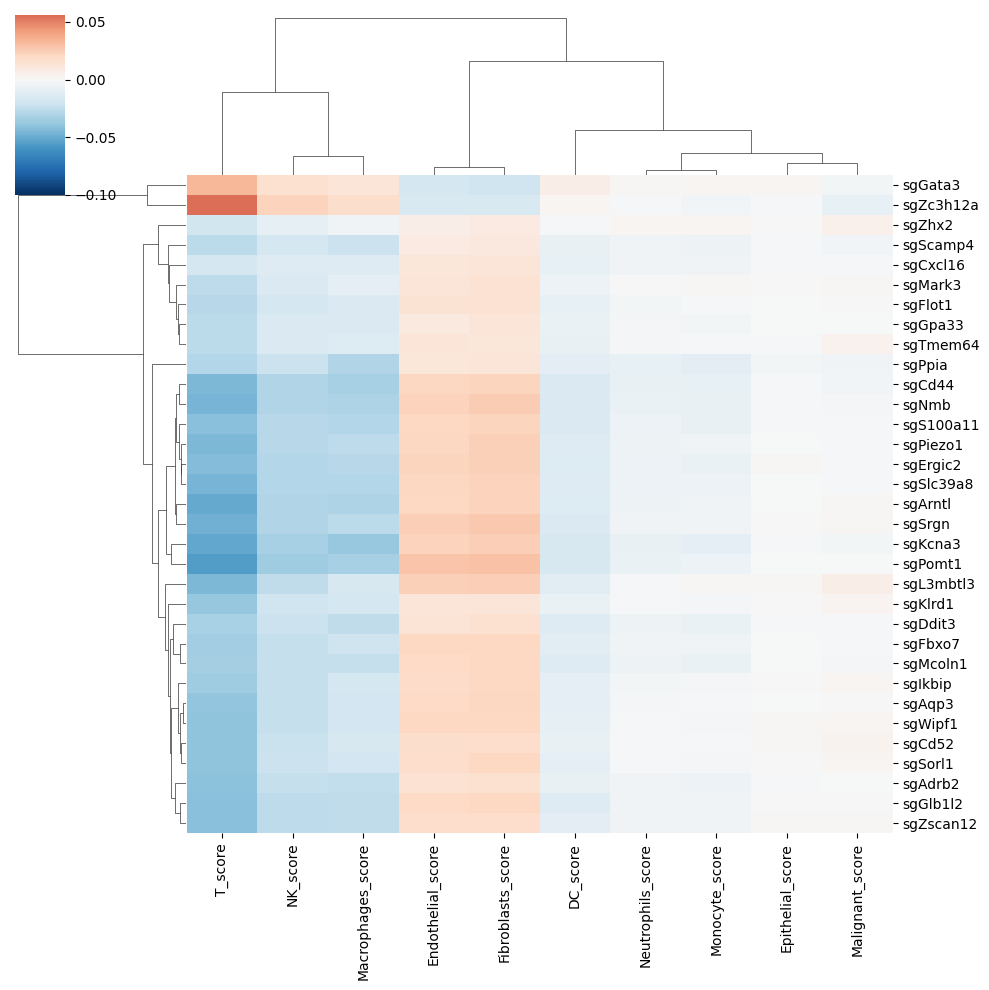

In [97]:
sns.clustermap(c_df, cmap="RdBu_r", vmin=-0.1, center=0)

# Only cluster 3

In [98]:
c_df = calculate_correlation(fdata[fdata.obs["cluster_cellcharter_givenk"] == 3], cdata[fdata.obs["cluster_cellcharter_givenk"] == 3], expr_term=[f"{marker}_score" for marker in markers], corr_type="spearmanr", control=True)

Extracting bin metric
Correlation with 12394 samples, 34 guides, 10 objectives.


 12%|█▏        | 4/34 [00:00<00:00, 36.33it/s]

100%|██████████| 34/34 [00:00<00:00, 36.88it/s]

Regression done!


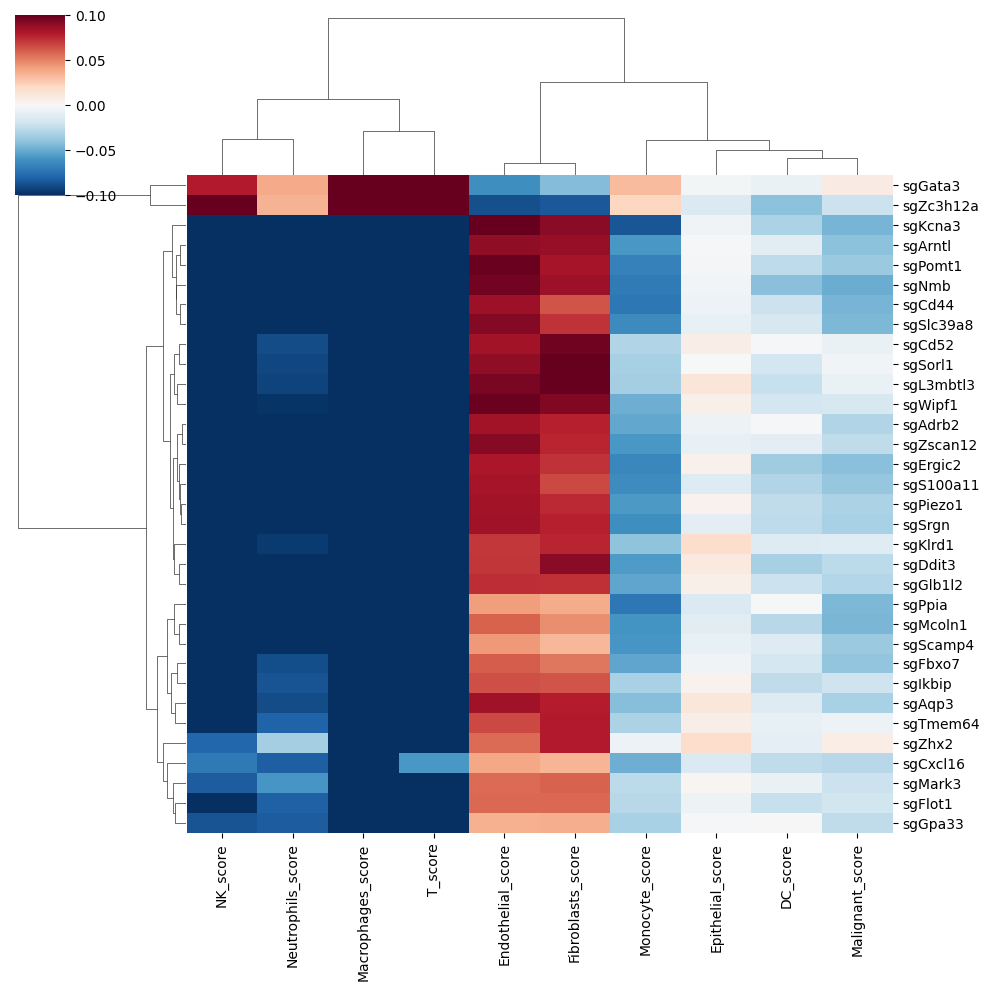

In [99]:
sns.clustermap(c_df, cmap="RdBu_r", vmax=0.1, vmin=-0.1, center=0)

# Only 5 and 9 and 11?

In [102]:
mask = np.isin(fdata.obs["cluster_cellcharter_givenk"], [4, 5, 7, 9])
c_df = calculate_correlation(fdata[mask], cdata[mask], expr_term=[f"{marker}_score" for marker in markers], corr_type="spearmanr", control=True)

Extracting bin metric
Correlation with 31593 samples, 34 guides, 10 objectives.


  0%|          | 0/34 [00:00<?, ?it/s]

100%|██████████| 34/34 [00:01<00:00, 20.91it/s]

Regression done!


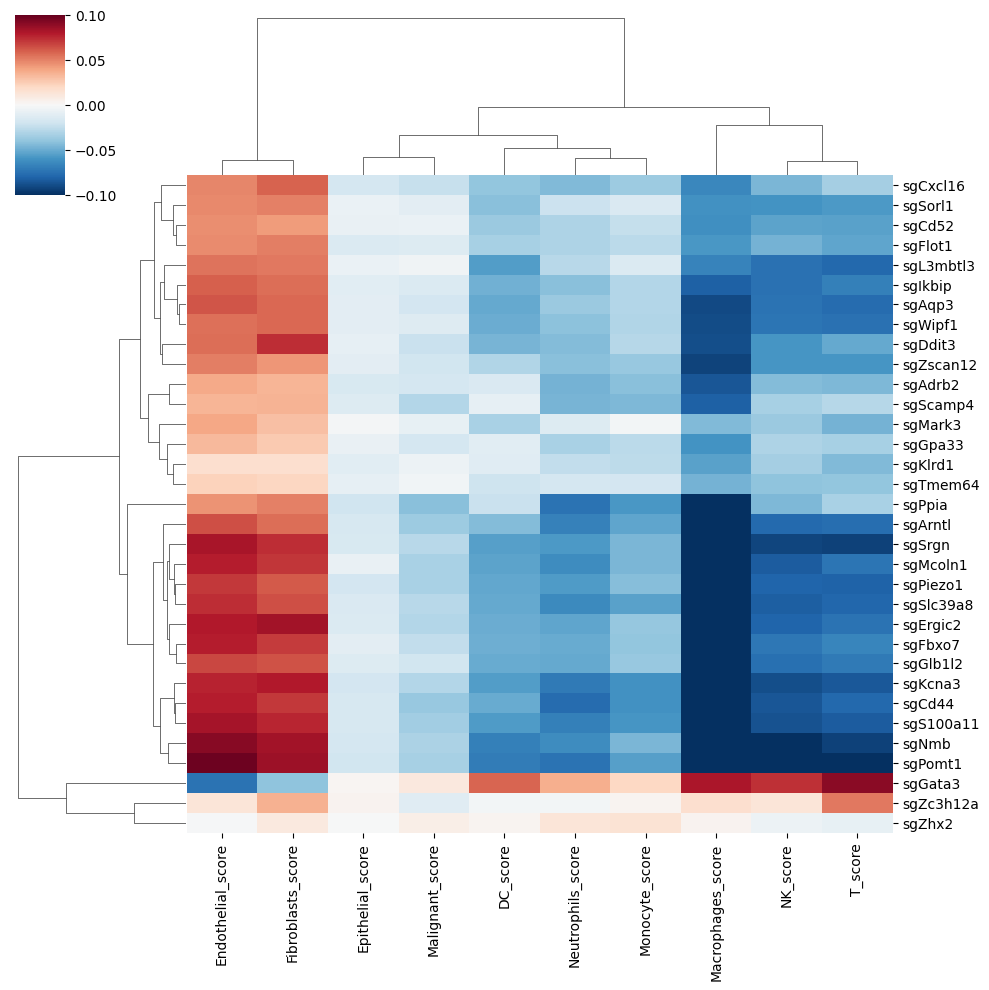

In [103]:
sns.clustermap(c_df, cmap="RdBu_r", vmax=0.1, vmin=-0.1, center=0)

# T signature

In [135]:
for marker in T_markers:
    genes = gene_mouse(T_markers[marker])
    mean_expression = np.zeros(len(fdata.obs_names))
    for gene in genes:
        if gene in fdata.var_names:
            mean_expression += fdata[:, gene].X.toarray().flatten()
    fdata.obs[f"{marker}_score"] = mean_expression

In [133]:
t_df = pd.DataFrame()
for guide in tqdm(cdata.var_names):
    mask = np.isin(fdata.obs["cluster_cellcharter_givenk"], [3]) & (cdata[:, guide].X > 0).T[0]
    if len(t_df) == 0: t_df = calculate_correlation(fdata[mask], cdata[mask, guide], expr_term=[f"{marker}_score" for marker in T_markers], corr_type="spearmanr", verbose=False)
    else: t_df = pd.concat([t_df, calculate_correlation(fdata[mask], cdata[mask, guide], expr_term=[f"{marker}_score" for marker in T_markers], corr_type="spearmanr", verbose=False)])

100%|██████████| 34/34 [00:01<00:00, 33.31it/s]


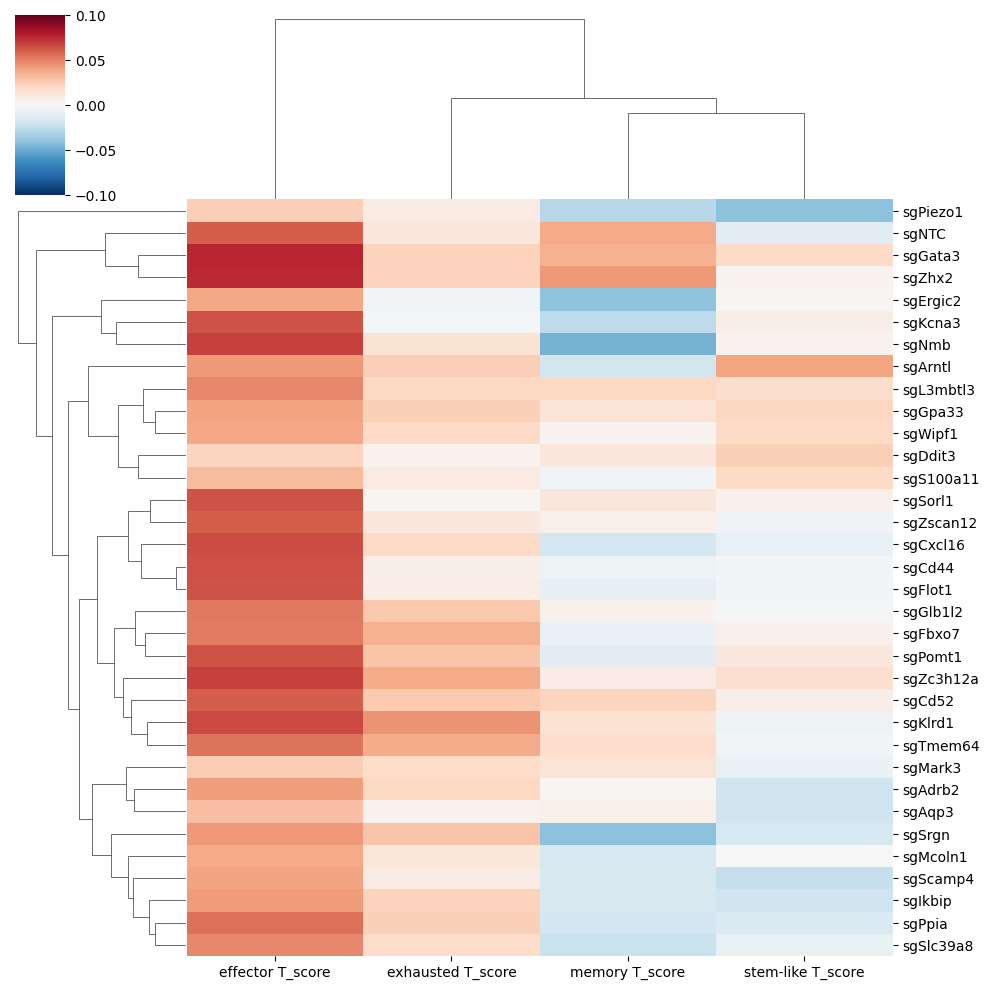

In [137]:
sns.clustermap(t_df, cmap="RdBu_r", vmax=0.1, vmin=-0.1, center=0)

In [138]:
t_df = pd.DataFrame()
for guide in tqdm(cdata.var_names):
    mask = (cdata[:, guide].X > 0).T[0]
    if len(t_df) == 0: t_df = calculate_correlation(fdata[mask], cdata[mask, guide], expr_term=[f"{marker}_score" for marker in T_markers], corr_type="spearmanr", verbose=False)
    else: t_df = pd.concat([t_df, calculate_correlation(fdata[mask], cdata[mask, guide], expr_term=[f"{marker}_score" for marker in T_markers], corr_type="spearmanr", verbose=False)])

100%|██████████| 34/34 [00:01<00:00, 24.18it/s]


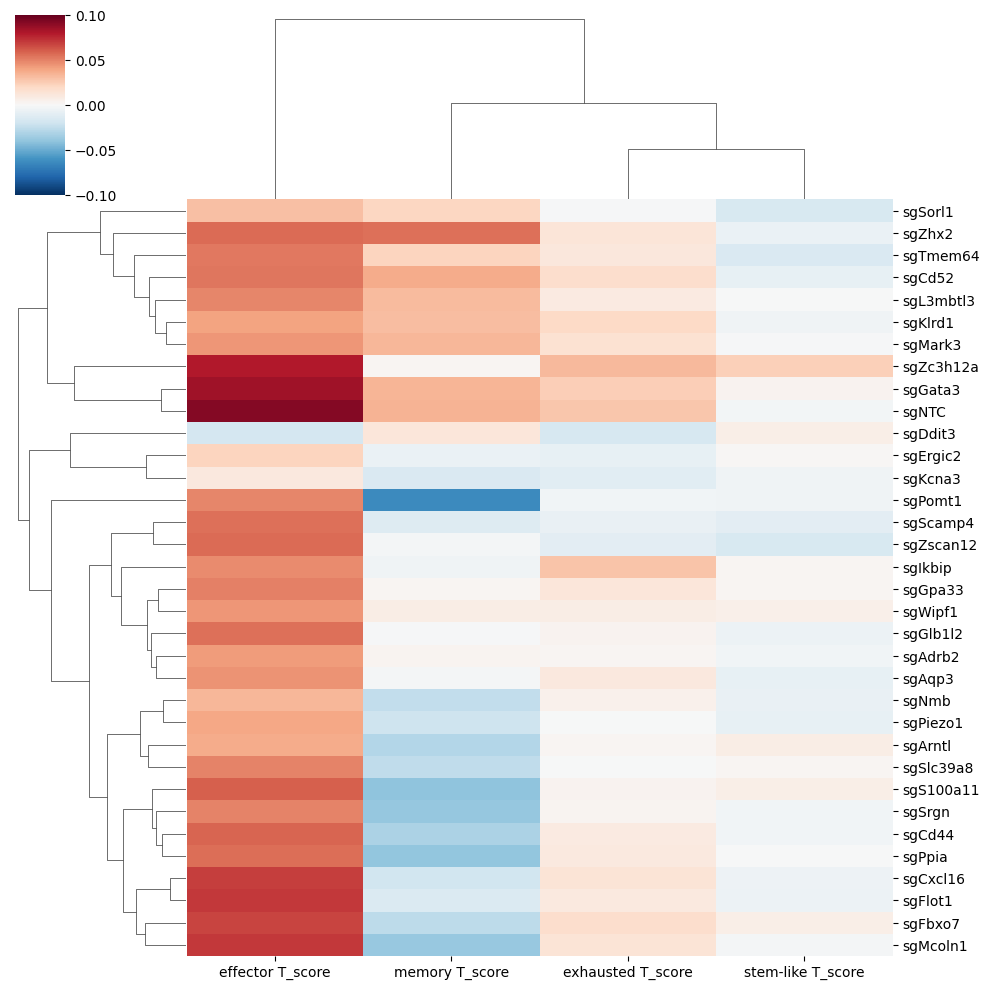

In [139]:
sns.clustermap(t_df, cmap="RdBu_r", vmax=0.1, vmin=-0.1, center=0)

In [157]:
t_df = pd.DataFrame()
for guide in tqdm(cdata.var_names):
    mask = np.isin(fdata.obs["cluster_cellcharter_givenk"], [3])& (cdata[:, guide].X > 7).T[0]
    if len(t_df) == 0: t_df = beta_regression(fdata[mask], cdata[mask, guide], expr_term=[f"{marker}_score" for marker in T_markers], verbose=False, max_iter=1000)
    else: t_df = pd.concat([t_df, beta_regression(fdata[mask], cdata[mask, guide], expr_term=[f"{marker}_score" for marker in T_markers], verbose=False, max_iter=1000)])

100%|██████████| 34/34 [00:03<00:00, 10.80it/s]


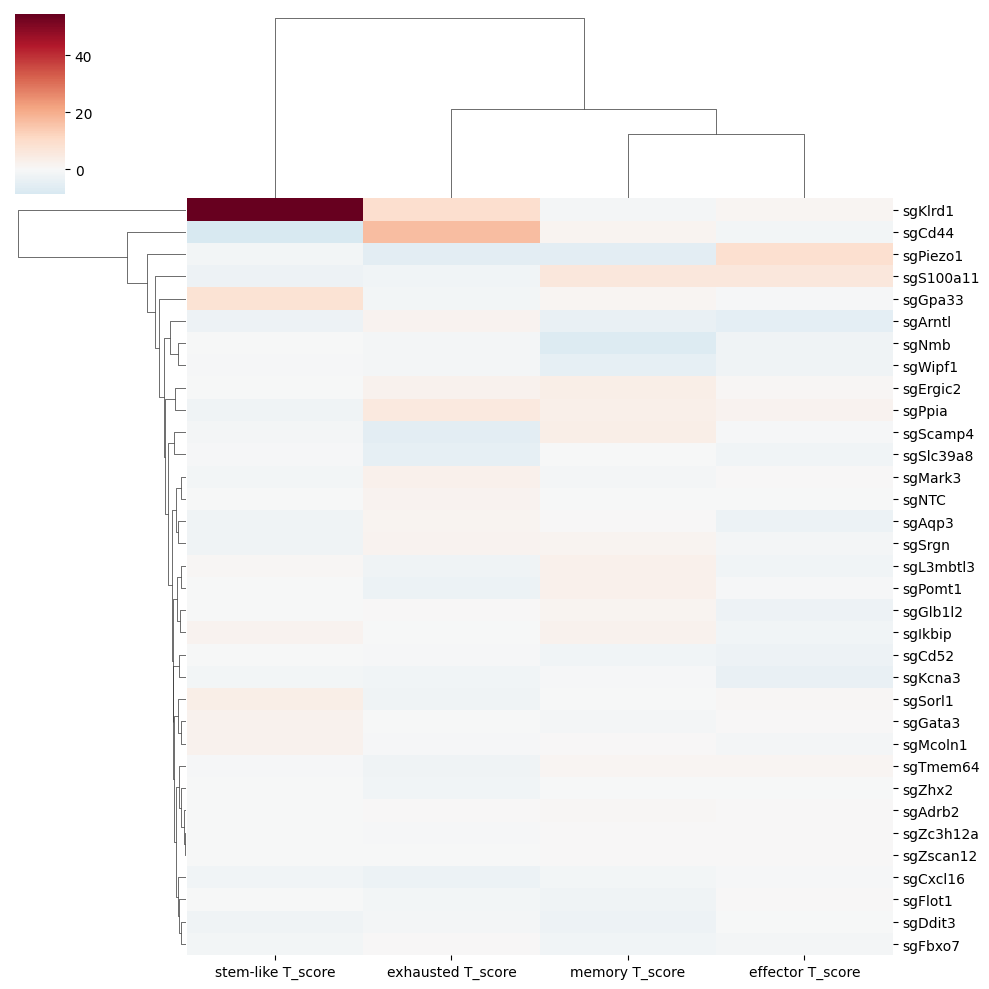

In [159]:
sns.clustermap(t_df, cmap="RdBu_r", center=0)